In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("l33tc0d3r/indian-food-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'indian-food-classification' dataset.
Path to dataset files: /kaggle/input/indian-food-classification


In [ ]:
import os
os.listdir('/kaggle/input/indian-food-classification/Food Classification')

['momos',
 'dhokla',
 'kaathi_rolls',
 'chole_bhature',
 'masala_dosa',
 'dal_makhani',
 'burger',
 'chai',
 'chapati',
 'paani_puri',
 'pav_bhaji',
 'pakode',
 'idli',
 'jalebi',
 'kadai_paneer',
 'samosa',
 'butter_naan',
 'pizza',
 'kulfi',
 'fried_rice']

In [ ]:
from PIL import Image

In [ ]:
data_dir='/kaggle/input/indian-food-classification/Food Classification'
valid_ext=['jpeg','jpg','bmp','png','webp']

In [ ]:
for image_class in os.listdir(data_dir):
    class_path = os.path.join(data_dir, image_class)
    if not os.path.isdir(class_path):
        continue

    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)

        try:
            #First read metadata to check format
            with Image.open(image_path) as img:
                img_format = img.format.lower()

            if img_format not in valid_ext:
                print(f"Invalid format: {image_path}, Detected format: {img_format}")
                continue   # don't delete yet

            #Second verify integrity
            with Image.open(image_path) as img:
                img.verify()

        except Exception as e:
            print(f"Corrupted image: {image_path}, Error: {e}")

Invalid format: /kaggle/input/indian-food-classification/Food Classification/momos/026.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/chole_bhature/038.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/chai/078.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/idli/026.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/kulfi/090.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/fried_rice/173.jpg, Detected format: mpo
Invalid format: /kaggle/input/indian-food-classification/Food Classification/fried_rice/043.jpg, Detected format: mpo


In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,seed=42,image_size=(224, 224))

Found 6269 files belonging to 20 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

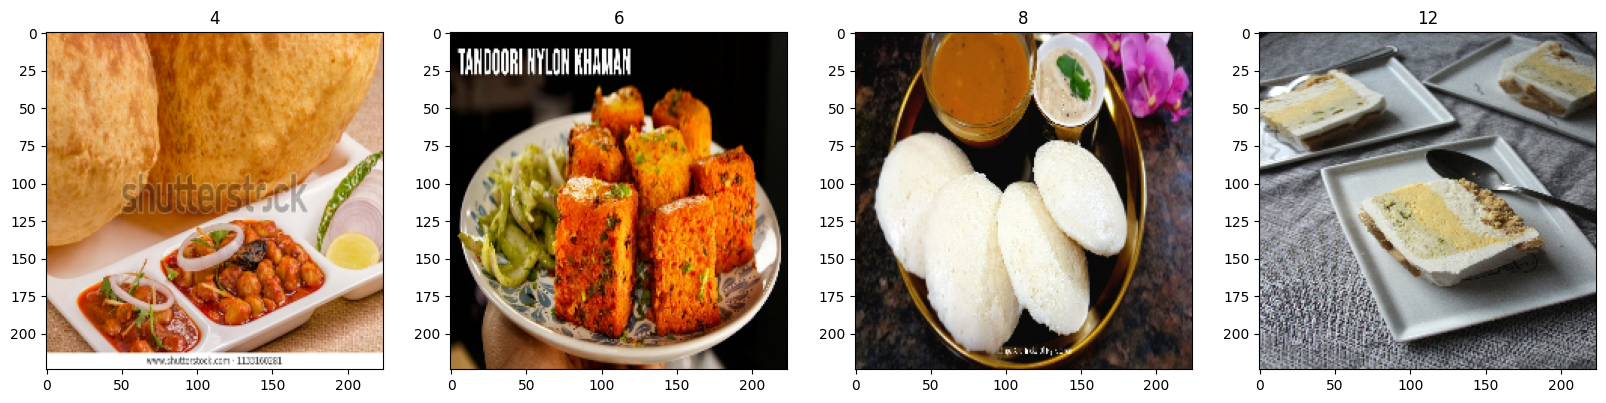

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# data = data.map(lambda x,y: (x/255, y))

In [ ]:
data = data.shuffle(buffer_size=6269, seed=42)

In [ ]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.1)

In [ ]:
train_size

137

In [ ]:
val_size

19

In [ ]:
train_ds = data.take(train_size)
val_ds   = data.skip(train_size).take(val_size)
test_ds  = data.skip(train_size + val_size)

In [ ]:
train_ds

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False   # Phase 1

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)

In [ ]:
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = tf.keras.layers.Dense(20, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 148s 538ms/step - accuracy: 0.1246 - loss: 3.0833 - val_accuracy: 0.5296 - val_loss: 1.9585
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 192s 520ms/step - accuracy: 0.4051 - loss: 2.0510 - val_accuracy: 0.7122 - val_loss: 1.3061
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 523ms/step - accuracy: 0.5489 - loss: 1.5757 - val_accuracy: 0.7500 - val_loss: 1.0692
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 133s 517ms/step - accuracy: 0.6349 - loss: 1.2944 - val_accuracy: 0.7812 - val_loss: 0.8675
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 133s 521ms/step - accuracy: 0.6610 - loss: 1.1469 - val_accuracy: 0.7911 - val_loss: 0.7791
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 133s 518ms/step - accuracy: 0.6830 - loss: 1.0833 - val_accuracy: 0.8125 - val_loss: 0.7178
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 518ms/step - accuracy: 0.7221 - loss: 0.9506 - val_accuracy: 0.8322 - val_loss: 0.6589
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 142s 521ms/step - accuracy: 0.7308 -

In [ ]:
base_model.trainable = True

# Freeze bottom layers, fine-tune top ones
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 147s 555ms/step - accuracy: 0.6769 - loss: 1.1304 - val_accuracy: 0.8109 - val_loss: 0.6317
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 138s 550ms/step - accuracy: 0.8049 - loss: 0.6753 - val_accuracy: 0.8602 - val_loss: 0.5286
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 137s 544ms/step - accuracy: 0.8345 - loss: 0.5604 - val_accuracy: 0.8694 - val_loss: 0.4869
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 143s 546ms/step - accuracy: 0.8715 - loss: 0.4377 - val_accuracy: 0.8520 - val_loss: 0.4947
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 141s 548ms/step - accuracy: 0.8780 - loss: 0.3937 - val_accuracy: 0.9095 - val_loss: 0.3249
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 138s 548ms/step - accuracy: 0.8940 - loss: 0.3443 - val_accuracy: 0.9293 - val_loss: 0.2389
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 137s 545ms/step - accuracy: 0.9115 - loss: 0.3000 - val_accuracy: 0.9227 - val_loss: 0.2335
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 138s 552ms/step - accuracy: 0.9127 -

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)

40/40 ━━━━━━━━━━━━━━━━━━━━ 68s 52ms/step - accuracy: 0.9622 - loss: 0.1331
Test Accuracy: 0.9593750238418579


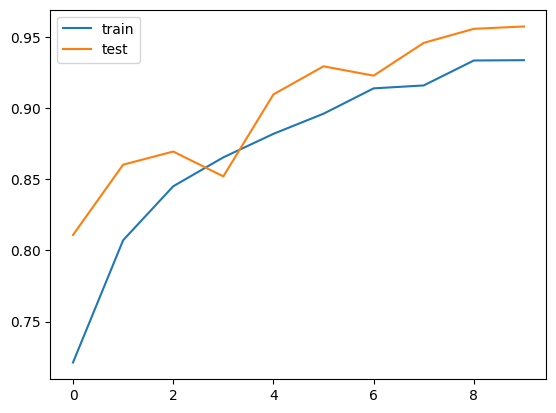

In [ ]:
plt.plot(history_fine.history['accuracy'])
plt.plot(history_fine.history['val_accuracy'])
plt.legend(['train','test'],loc='upper left')
plt.show()

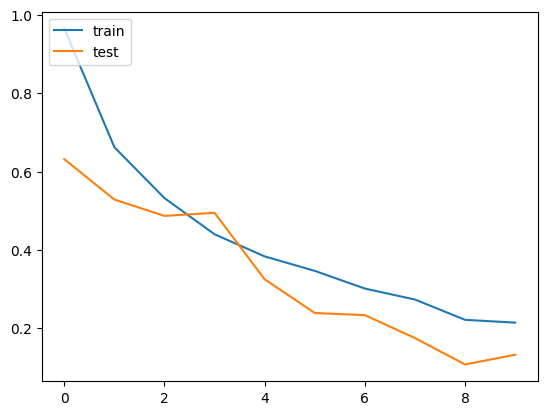

In [ ]:
plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.legend(['train','test'],loc='upper left')
plt.show()

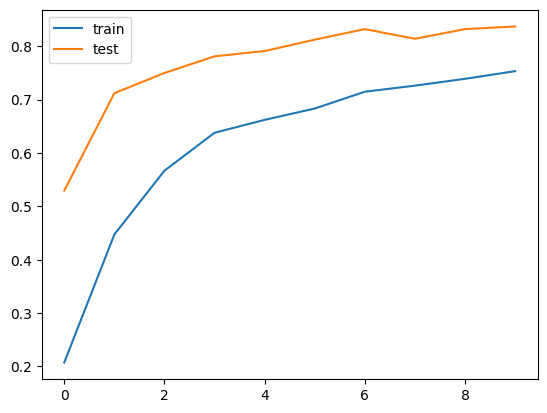

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','test'],loc='upper left')
plt.show()

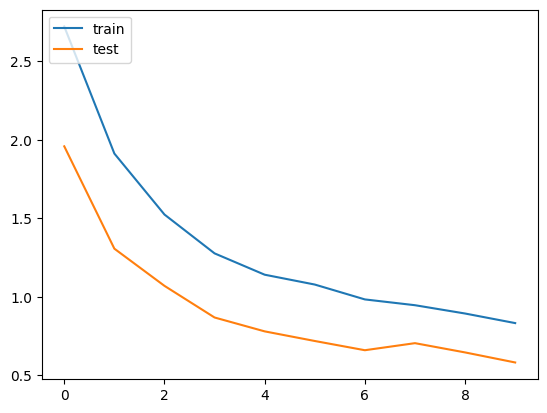

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','test'],loc='upper left')
plt.show()

In [ ]:
model.save("indian_food_classifer.h5")

In [ ]:
model.save("indian_food_classifier.keras")

In [ ]:
import numpy as np
from sklearn.metrics import classification_report
import os

# Get true labels and predictions for the test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    y_true.extend(labels.numpy())
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Get class names from the dataset by listing directories and sorting them
# This ensures the order matches what tf.keras.utils.image_dataset_from_directory would use.
class_names = sorted(os.listdir(data_dir))


print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━